## Imports and setup

In [1]:
# only run this cell once!
import os 
notebook_path = os.getcwd()
os.chdir(os.path.dirname(notebook_path))

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

from performance.utils import process_log_dir

import mplhep as hep
plt.style.use(hep.style.ATLAS)
plt.rcParams['legend.loc'] = 'upper right'

TITLE = "1 NVIDIA A100 SXM4 80GB on Perlmutter, ODD detector, traccc v0.20.0"

log_dir = 'data/logs_odd_traccc_nom'
data = process_log_dir(log_dir)

Skipping performance.png. Not a log file.


### Plot

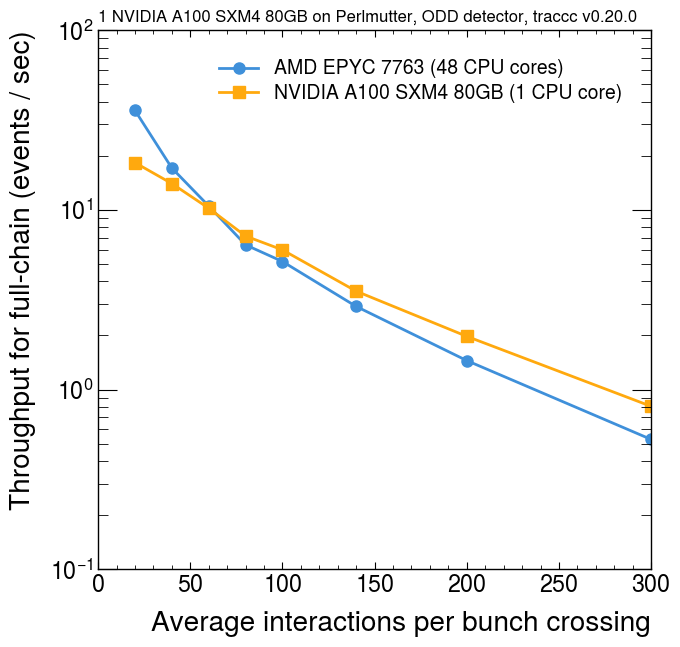

In [3]:
plt.figure(figsize=(7, 7))

cpu_mu = sorted(data['cpu'].keys())
cpu_time = [data['cpu'][mu] for mu in cpu_mu]
plt.plot(cpu_mu, cpu_time, label='AMD EPYC 7763 (48 CPU cores)', marker='o')

gpu_mu = sorted(data['gpu'].keys())
gpu_time = [data['gpu'][mu] for mu in gpu_mu]

plt.plot(gpu_mu, gpu_time, label='NVIDIA A100 SXM4 80GB (1 CPU core)', marker='s')
plt.xlabel('Average interactions per bunch crossing', loc='right')
plt.ylabel('Throughput for full-chain (events / sec)', loc='top')
plt.title(TITLE, loc='left', fontsize=12)
plt.legend()
plt.yscale('log')

## Compare to peak aaS numbers

In [4]:
import os
import glob

from performance.utils import process_csv_dir

def extract_mu_value(directory_path):
    """Extract mu value from directory name."""
    match = re.search(r'mu(\d+)', os.path.basename(directory_path))
    if match:
        return int(match.group(1))
    return None

def get_max_throughput(directory):
    """Get throughput for the last model instance in the directory."""
    try:
        # Process data
        _, gpu_data_instances = process_csv_dir(directory)
        
        if not gpu_data_instances:
            return None
            
        # Get the highest instance number
        max_instance = max(gpu_data_instances.keys())
        data = gpu_data_instances[max_instance]
        
        # Filter data for the specific concurrency
        filtered_data = data[data['Concurrency'] == max_instance]
        
        if filtered_data.empty:
            return None
            
        # Return throughput
        return filtered_data['Inferences/Second'].values[0]
    except Exception as e:
        print(f"Error processing {directory}: {e}")
        return None

In [5]:
pattern = os.path.join('data', 'traccc-aaS_nominal_mu*_10event')
mu_dirs = glob.glob(pattern)

data = []
for mu_dir in mu_dirs:
    mu_value = extract_mu_value(mu_dir)
    if mu_value is not None:
        throughput = get_max_throughput(mu_dir)
        if throughput is not None:
            data.append((mu_value, throughput))
data

[(100, np.float64(7.16975)),
 (140, np.float64(3.86679)),
 (300, np.float64(0.827548)),
 (60, np.float64(13.3429)),
 (20, np.float64(47.2331)),
 (200, np.float64(2.09045)),
 (40, np.float64(22.8925)),
 (80, np.float64(8.79944))]

In [6]:
# sort data by mu value
data = sorted(data, key=lambda x: x[0])
mu_values = [x[0] for x in data]
throughputs = [x[1] for x in data]

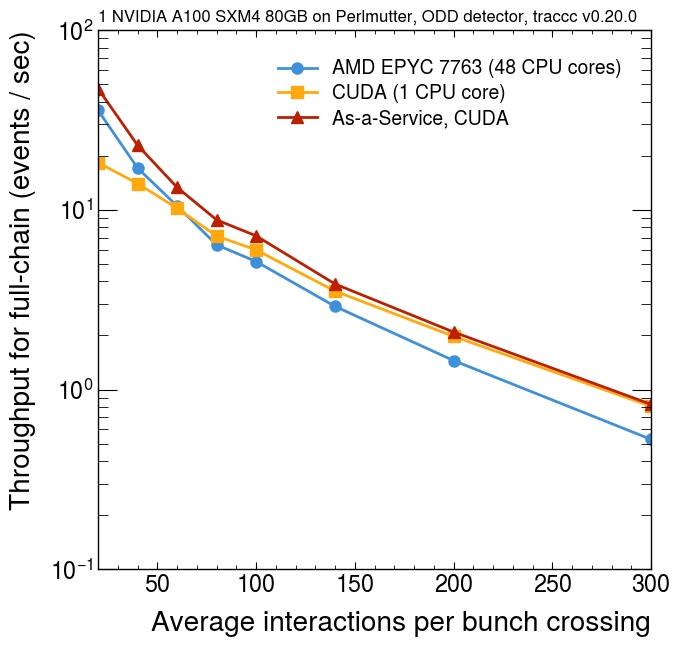

In [7]:
plt.figure(figsize=(7, 7))
plt.plot(cpu_mu, cpu_time, label='AMD EPYC 7763 (48 CPU cores)', marker='o')
plt.plot(gpu_mu, gpu_time, label='CUDA (1 CPU core)', marker='s')
plt.plot(mu_values, throughputs, label='As-a-Service, CUDA', marker='^')
plt.xlabel('Average interactions per bunch crossing', loc='right')
plt.ylabel('Throughput for full-chain (events / sec)', loc='top')
plt.title(TITLE, loc='left', fontsize=12)
plt.xlim(20, 300)
plt.legend()
plt.yscale('log')
plt.show()

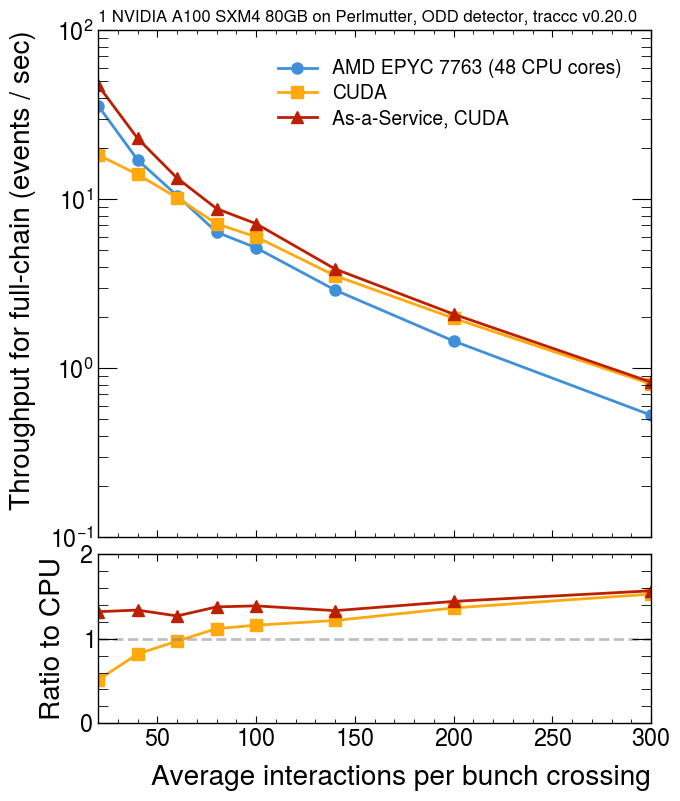

In [8]:
# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), height_ratios=[3, 1], sharex=True)
plt.subplots_adjust(hspace=0.05)  # Reduce space between plots

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Top plot
line1 = ax1.plot(cpu_mu, cpu_time, label='AMD EPYC 7763 (48 CPU cores)', marker='o', color=colors[0])
line2 = ax1.plot(gpu_mu, gpu_time, label='CUDA', marker='s', color=colors[1])
line3 = ax1.plot(mu_values, throughputs, label='As-a-Service, CUDA', marker='^', color=colors[2])
ax1.set_ylabel('Throughput for full-chain (events / sec)', loc='top')
ax1.set_title(TITLE, loc='left', fontsize=12)
ax1.set_xlim(20, 300)
ax1.legend()
ax1.set_yscale('log')

# Calculate ratios
# Interpolate GPU/CPU values to match mu points
cpu_interp = np.interp(mu_values, cpu_mu, cpu_time)
gpu_interp = np.interp(mu_values, gpu_mu, gpu_time)

# Calculate ratios
ratio_gpu_cpu = np.array(throughputs) / cpu_interp
ratio_service_cpu = gpu_interp / cpu_interp

# Bottom plot (ratio)
ax2.plot(mu_values, ratio_service_cpu, marker='s', label='CUDA/CPU', color=colors[1])
ax2.plot(mu_values, ratio_gpu_cpu, marker='^', label='As-a-Service/CPU', color=colors[2])
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Average interactions per bunch crossing', loc='right')
ax2.set_ylabel('Ratio to CPU', loc='center')

plt.show()

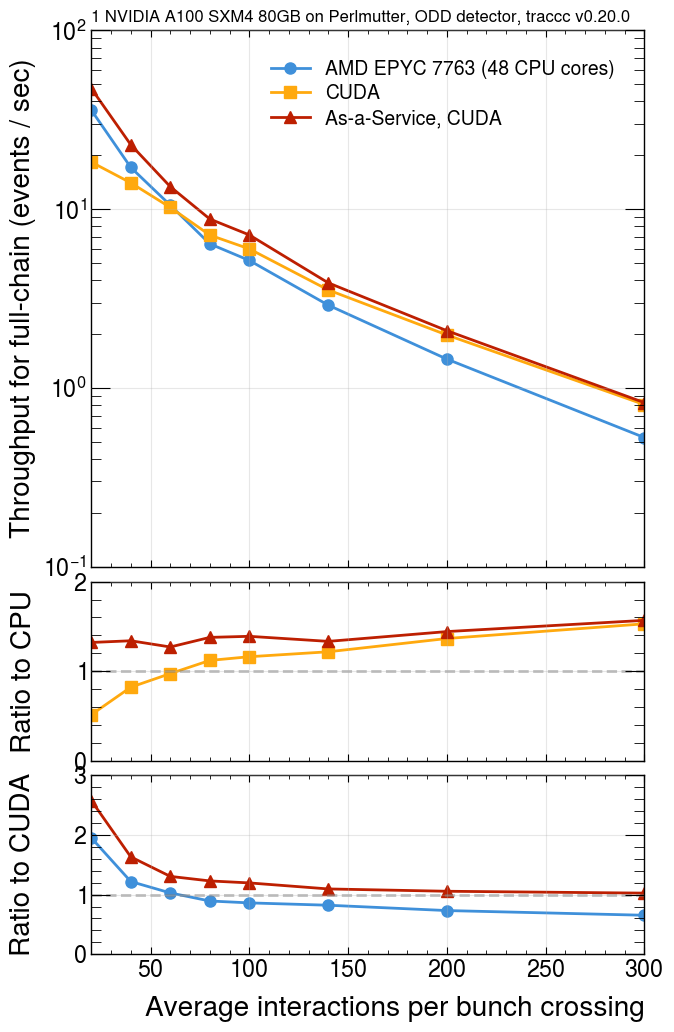

In [9]:
# Create figure with three subplots sharing x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 12), height_ratios=[3, 1, 1], sharex=True)
plt.subplots_adjust(hspace=0.05)  # Reduce space between plots

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Align y-axis labels
ylabel_x = -0.1  # Common x-position for all y-labels

# Top plot
line1 = ax1.plot(cpu_mu, cpu_time, label='AMD EPYC 7763 (48 CPU cores)', marker='o', color=colors[0])
line2 = ax1.plot(gpu_mu, gpu_time, label='CUDA', marker='s', color=colors[1])
line3 = ax1.plot(mu_values, throughputs, label='As-a-Service, CUDA', marker='^', color=colors[2])
ax1.set_ylabel('Throughput for full-chain (events / sec)', loc='center')
ax1.yaxis.set_label_coords(ylabel_x, 0.5)
ax1.set_title(TITLE, loc='left', fontsize=12)
ax1.set_xlim(20, 300)
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Calculate ratios
cpu_interp = np.interp(mu_values, cpu_mu, cpu_time)
gpu_interp = np.interp(mu_values, gpu_mu, gpu_time)

# Calculate ratios relative to CPU
ratio_cuda_cpu = gpu_interp / cpu_interp
ratio_service_cpu = np.array(throughputs) / cpu_interp

# Middle plot (ratio to CPU)
ax2.plot(mu_values, ratio_cuda_cpu, marker='s', label='CUDA/CPU', color=colors[1])
ax2.plot(mu_values, ratio_service_cpu, marker='^', label='As-a-Service/CPU', color=colors[2])
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Ratio to CPU', loc='center')
ax2.yaxis.set_label_coords(ylabel_x, 0.5)
ax2.grid(True, alpha=0.3)

# Calculate ratios relative to CUDA
ratio_cpu_cuda = cpu_interp / gpu_interp
ratio_service_cuda = np.array(throughputs) / gpu_interp

# Bottom plot (ratio to CUDA)
ax3.plot(mu_values, ratio_cpu_cuda, marker='o', label='CPU/CUDA', color=colors[0])
ax3.plot(mu_values, ratio_service_cuda, marker='^', label='As-a-Service/CUDA', color=colors[2])
ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Average interactions per bunch crossing', loc='right')
ax3.set_ylabel('Ratio to CUDA', loc='center')
ax3.yaxis.set_label_coords(ylabel_x, 0.5)
ax3.grid(True, alpha=0.3)

plt.show()